In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


# Data extraction

In [ ]:
train_file = "./dataset/sign_mnist_train.csv"
test_file = "./dataset/sign_mnist_test.csv"



In [ ]:
data = pd.read_csv(train_file,header=0)
test_data = pd.read_csv(test_file,header=0)

def parse_data(data):
    x = data.drop('label', axis=1).to_numpy()
    y = pd.DataFrame(data =  data['label'] , columns = ['label']).to_numpy()
    return x, y.ravel()
def lab2char(label):
    return chr( ord('a')  + label)

x,y = parse_data(data)
x_test, y_test = parse_data(test_data)

In [ ]:
print(type(x), type(y) )
print(x.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(27455, 784) (27455,)


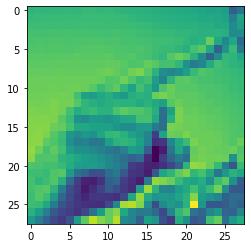

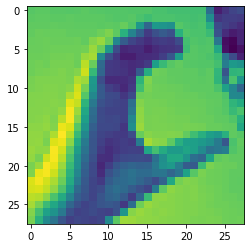

In [ ]:
def vec2img(xi, dim = 28):
    return xi.reshape((dim,dim))

def show_image(img):
    plt.imshow(img)
    plt.show()
    
# print(lab2char( y[1]))
show_image(vec2img(x[1]))
show_image(vec2img(x[2]))

## Dimention Reduction

In [ ]:
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import pywt
import pywt.data
from numpy import imag


In [ ]:
x_train_original = x
x_test_original = x_test


In [5]:
def Haar(imagen, cortes):
  for i in range(cortes):
    imagen, (LH, HL, HH) = pywt.dwt2(imagen, 'haar') 
  return imagen

def haar_reduction(X, cuts = 2):
    sample_img = vec2img(X[0])
    sample_haar = Haar(sample_img,cuts)
    features = len(sample_haar.ravel())
    rX = np.ones((np.shape(X)[0], features))
    for i, img in enumerate(X):
      # print(i)
      rX[i] = Haar(vec2img(img), cuts).ravel()

    return rX



In [ ]:
x_reduce  = haar_reduction(x_train_original)
x_test_reduce  = haar_reduction(x_test_original)

In [ ]:
print(x.shape, x_test.shape)

(27455, 784) (7172, 784)


## Clasification

In [ ]:
# models
import imp
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import scipy

#score methods
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#metrics
import sklearn as sk
import sklearn.utils
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

#utils
import seaborn as sns
from sklearn.utils import resample
from math import ceil
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
def plot_scores(scores, xerr ,model_name = "DS", x_label = "depth"):
    yerr = [np.mean(score) for score in scores]
    err = [np.std(score) for score in scores]
    plt.style.use('seaborn-whitegrid')
    plt.errorbar(xerr, yerr, err, linestyle = 'dashed', fmt = 'o', ecolor='lightgray', elinewidth=3, capsize=0)
    plt.title(f'Error distribution for {model_name}')
    plt.ylabel('Error distribution')
    # plt.xlabel(x_label)

def cv_evaluate_model(models, X, y, name = "Classifier", kfolds = 10):
    scores = []
    for modelclf in tqdm(models,  leave=False, desc=f'cross predict for{name}'):
        kfold = KFold(n_splits = kfolds, shuffle= True)
        score = cross_val_score(estimator=modelclf, X=x, y=y, cv= kfold , n_jobs=-1)
        scores.append(score)
    return scores


In [ ]:
print(x.shape, y.shape)
print(x_test.shape, y_test.shape)

(27455, 5) (27455,)
(7172, 5) (7172,)


In [ ]:
def bias_variance_decomposition(y_pred, y_real):
    modal_predictions = scipy.stats.mode(y_pred, axis=0)[0][0]
    mean_loss = np.mean(y_pred != y_real)
    mean_bias = np.mean(modal_predictions != y_real)
    mean_var = np.mean(modal_predictions != y_pred)
    
    return mean_loss, mean_bias, mean_var


In [ ]:
def cv_sample(X, y, folds = 10, random_state = 42):
    kfold = KFold(n_splits = folds, shuffle= True)
    return kfold.split(X,y)

def cross_validation(X, y, X_t, y_t, model, model_name = '', n_experiments = 10):
    presicion = np.zeros((n_experiments, 1))
    recall = np.zeros((n_experiments, 1))
    f1 = np.zeros((n_experiments, 1))
    auc = np.zeros((n_experiments, 1))
    loss = np.zeros((n_experiments, 1))
    bias = np.zeros((n_experiments, 1))
    var = np.zeros((n_experiments, 1))
 
    kfold = KFold(n_splits=  10, shuffle= True, random_state= 42)
    i = 0
    for train,test in tqdm(kfold.split(X), leave=False, total=kfold.get_n_splits(), desc=f"k-fold with {model_name}") :
        xb, yb  = x[train], y[train]
        clf  = model.fit(xb, yb)
        y_pred = clf.predict(X_t)
        #presicion
        presicion[i] = sklearn.metrics.precision_score(y_t, y_pred, average = 'micro')
        #recall
        recall[i]   = sklearn.metrics.recall_score(y_t, y_pred, average = 'macro')
        #f1 
        f1[i] = sklearn.metrics.f1_score(y_t, y_pred, average = 'macro')
        #aux
        y_pred_proba = clf.predict_proba(X_t)
        auc[i] = sklearn.metrics.roc_auc_score(y_test, y_pred_proba, multi_class = 'ovr')
        loss[i], bias[i], var[i] = bias_variance_decomposition(y_pred, y_t)
        i = i + 1
    
    df = pd.DataFrame(data=[[presicion.mean(), recall.mean(), f1.mean(), auc.mean(), loss.mean(), bias.mean(), var.mean()]], columns=['presicion', 'recall', 'f1', 'auc', 'loss', 'bias', 'var'])
    return df   


In [ ]:
from pyexpat import model
from statistics import mode
from numpy import average
from sklearn import multiclass


def bs_sample(X,y, random_state = 42):    
    ind = np.array( [i for i in range(X.shape[0])] )
    sample = resample(ind, random_state = random_state)
    test_sample = np.delete(ind, sample)

    xb, yb = X[sample], y[sample] 
    xt ,yt  = X[test_sample] , y[test_sample]
    return xb, yb, xt, yt        

def Boostrap(X, y, X_t, y_t, model, model_name = '', n_experiments = 10):
    presicion = np.zeros((n_experiments, 1))
    recall = np.zeros((n_experiments, 1))
    f1 = np.zeros((n_experiments, 1))
    auc = np.zeros((n_experiments, 1))
    loss = np.zeros((n_experiments, 1))
    bias = np.zeros((n_experiments, 1))
    var = np.zeros((n_experiments, 1))


    for i in tqdm(range(n_experiments),  leave=False, desc=f'Boostraping {model_name}'):
        #fit 
        xb, yb, _, _ = bs_sample(X,y, 42 + 1)
        clf  = model.fit(xb, yb)
        #predict
        y_pred = clf.predict(X_t)
        #presicion
        presicion[i] = sklearn.metrics.precision_score(y_t, y_pred, average = 'micro')
        #recall
        recall[i]   = sklearn.metrics.recall_score(y_t, y_pred, average = 'macro')
        #f1 
        f1[i] = sklearn.metrics.f1_score(y_t, y_pred, average = 'macro')
        #aux
        y_pred_proba = clf.predict_proba(X_t)
        auc[i] = sklearn.metrics.roc_auc_score(y_t, y_pred_proba, multi_class = 'ovr')
        loss[i], bias[i], var[i] = bias_variance_decomposition(y_pred, y_t)
        i = i + 1
    

    df = pd.DataFrame(data=[[presicion.mean(), recall.mean(), f1.mean(), auc.mean(), loss.mean(), bias.mean(), var.mean()]], columns=['presicion', 'recall', 'f1', 'auc', 'loss', 'bias', 'var'])

    return df


# Testing

In [ ]:
dst_changes =  [pow(2, i) for i in range(2, 8)]
dst_hyper = "Depth"
dst_models = [ tree.DecisionTreeClassifier(max_depth= i) for i in dst_changes]
dst_names  = [f"DST with max depth {i}"for i in dst_changes]

cnn_changes = [pow(2, i ) for i in range(2, 7)]
cnn_models = [ KNeighborsClassifier(n_neighbors = i, n_jobs= 4) for i in cnn_changes]
cnn_names  = [f"CNN with k {i}" for i in cnn_changes]
cnn_hyper = "Knn"

svm_changes = [pow(2, i ) for i in range(-1, 12,2)]
svm_models = [ svm.SVC(decision_function_shape='ovr', C = i, probability= True) for i in svm_changes]
svm_names  = [f"SVM with C {i}" for i in svm_changes]
svm_hyper = "C"

In [ ]:
def test_models(X, y, Xt, yt, models, names, hyper, changes):
    df_lst = []
    for i, model in enumerate(tqdm(models , desc= "Testing models with k fold")):
        df_lst.append( cross_validation(X,y, Xt, yt , model, names[i])  )
        df_lst[-1]['sampling'] = "KFold"
        df_lst[-1][hyper] = changes[i]
    
    for i, model in enumerate(tqdm(models,desc= "Testing models with Boostrap")):
        df_lst.append( Boostrap(X,y, Xt, yt , model, names[i])  )
        df_lst[-1]['sampling'] = "Boostrap"
        df_lst[-1][hyper] = changes[i]

    return df_lst        


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# from sklearn.pipeline import Pipeline
# from sklearn.naive_bayes import GaussianNB
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# x_reduce
# x_test_reduce
lda = LDA()
# scaler = MinMaxScaler()

x_reduce  = haar_reduction(x_train_original)
x_test_reduce  = haar_reduction(x_test_original)

x = lda.fit_transform(x_reduce, y)
x_test = lda.transform(x_test_reduce)

In [ ]:
print(x_train_original.shape, x_test_original.shape)
print(x_reduce.shape, x_test_reduce.shape)
print(x.shape, x_test.shape)

(27455, 784) (7172, 784)
(27455, 49) (7172, 49)
(27455, 23) (7172, 23)


In [ ]:
cnn_dfs = test_models(x, y, x_test, y_test, cnn_models, cnn_names, cnn_hyper, cnn_changes)
cnn_res = pd.concat(cnn_dfs, ignore_index= True)
cnn_res.sort_values(by=['presicion'], ascending=False).head()

Testing models with Boostrap: 100%|██████████| 5/5 [00:39<00:00,  8.00s/it]


,presicion,recall,f1,auc,loss,bias,var,sampling,Knn
5,0.825711,0.825913,0.816281,0.919476,0.174289,0.930563,0.922895,Boostrap,4
1,0.825683,0.825455,0.816104,0.933680,0.174317,0.930563,0.923076,KFold,8
0,0.824526,0.824224,0.814634,0.923609,0.175474,0.930563,0.922574,KFold,4
6,0.824456,0.824376,0.814581,0.928371,0.175544,0.930563,0.923313,Boostrap,8
2,0.822699,0.822477,0.813540,0.952252,0.177301,0.930563,0.923187,KFold,16


In [ ]:
dst_dfs = test_models(x, y, x_test, y_test, dst_models, dst_names, dst_hyper, dst_changes)
dst_res = pd.concat(dst_dfs, ignore_index= True)
dst_res.sort_values(by=['presicion'], ascending=False).head()

Testing models with Boostrap: 100%|██████████| 6/6 [01:02<00:00, 10.43s/it]


,presicion,recall,f1,auc,loss,bias,var,sampling,Depth
11,0.521640,0.506466,0.502875,0.742852,0.478360,0.944311,0.939668,Boostrap,128
4,0.517289,0.504532,0.501132,0.741791,0.482711,0.944325,0.937019,KFold,64
5,0.516230,0.501953,0.498604,0.740477,0.483770,0.942206,0.936656,KFold,128
2,0.516188,0.502668,0.500232,0.755660,0.483812,0.948299,0.935597,KFold,16
3,0.515937,0.504097,0.500076,0.741545,0.484063,0.939571,0.936893,KFold,32


In [ ]:
svm_dfs = test_models(x, y , x_test, y_test , svm_models, svm_names, svm_hyper, svm_changes)
svm_res = pd.concat(svm_dfs, ignore_index= True)
svm_res.sort_values(by=['presicion'], ascending=False).head()

Testing models with Boostrap: 100%|██████████| 7/7 [32:56<00:00, 282.33s/it]


,presicion,recall,f1,auc,loss,bias,var,sampling,C
7,0.844255,0.839023,0.828873,0.985763,0.155745,0.930563,0.921082,Boostrap,0.5
8,0.844116,0.838833,0.829236,0.986678,0.155884,0.930563,0.921221,Boostrap,2.0
1,0.843126,0.837916,0.828136,0.986722,0.156874,0.930563,0.921277,KFold,2.0
0,0.841035,0.835471,0.825772,0.986306,0.158965,0.930563,0.922992,KFold,0.5
2,0.838553,0.833805,0.823553,0.986729,0.161447,0.930563,0.922476,KFold,8.0


In [ ]:
svm_res.to_csv("res/svm1.csv", index = False)
cnn_res.to_csv("res/cnn1.csv", index = False)
dst_res.to_csv("res/dst1.csv", index = False)

Live Webcam

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import pickle

import cv2
import pywt
import pywt.data
from numpy import imag
import numpy as np

def Haar(imagen, cortes):
  for i in range(cortes):
    imagen, (LH, HL, HH) = pywt.dwt2(imagen, 'haar') 
  return imagen

def haar_reduction(X, cuts = 2):
    sample_img = vec2img(X[0])
    sample_haar = Haar(sample_img,cuts)
    features = len(sample_haar.ravel())
    rX = np.ones((np.shape(X)[0], features))
    for i, img in enumerate(X):
      # print(i)
      rX[i] = Haar(vec2img(img), cuts).ravel()

    return rX

def vec2img(xi, dim = 28):
    return xi.reshape((dim,dim))

filename = 'cnn_model.sav'
l_filename = 'lda_model.sav'


model = pickle.load(open(filename, 'rb'))

lda = pickle.load(open(l_filename, 'rb'))
#print(loaded_model)
print(lda)

LinearDiscriminantAnalysis()


In [4]:
background = None
accumulated_weight = 0.5

#Creating the dimensions for the ROI...

ROI_top = 300
ROI_bottom = 900
ROI_right = 150
ROI_left = 550

def cal_accum_avg(frame, accumulated_weight):
    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None
    cv2.accumulateWeighted(frame, background, accumulated_weight)
    
def segment_hand(frame, threshold=25):
    global background
    diff = cv2.absdiff(background.astype("uint8"), frame)
    _ , thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    contours = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    try:
        if len(contours) == 0:
            return None
        else:
            hand_segment_max_cont = max(contours, key=cv2.contourArea)      
            return (thresholded, hand_segment_max_cont)
    except TypeError:
        return None
    
cam = cv2.VideoCapture(0)
num_frames = 0
element = 10
num_imgs_taken = 0

while True:
    ret, frame = cam.read()
    # flipping the frame to prevent inverted image of captured frame...
    frame = cv2.flip(frame, 1)
    frame_copy = frame.copy()
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]
    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)
    if num_frames < 60:
        cal_accum_avg(gray_frame, accumulated_weight)
        if num_frames <= 59:
            
            cv2.putText(frame_copy, "FETCHING BACKGROUND PLEASE WAIT",
                        (80, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
    else: 
        # Segmenting the hand region...
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            # unpack the thresholded img and the max_contour...
            thresholded, hand_segment = hand
            dim = (28, 28)

            # resize image
            thresholded = cv2.resize(thresholded, dim, interpolation = cv2.INTER_AREA)
            
            #print(thresholded.shape)

            reduce_img = Haar(thresholded, cortes= 2).ravel()
            pre_img =  np.reshape(reduce_img, (1, -1))
            #print(pre_img.shape)
            pre_img =  lda.transform(pre_img)
            print(chr( ord('a')  + model.predict(pre_img)[0]) )

            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)],
                             -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames), (70, 45),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            cv2.putText(frame_copy, str(num_imgs_taken) + 'images' +"For" 
                        + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1,
                        (0,0,255), 2)
            
            # Displaying the thresholded image
            cv2.imshow("Thresholded Hand Image", thresholded)
            num_imgs_taken +=1
        else:
            cv2.putText(frame_copy, 'No hand detected...', (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    # Drawing ROI on frame copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,128,0), 3)
    
    cv2.putText(frame_copy, "DataFlair hand sign recognition_ _ _", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    
    # increment the number of frames for tracking
    num_frames += 1
    # Display the frame with segmented hand
    cv2.imshow("Sign Detection", frame_copy)
    # Closing windows with Esc key...(any other key with ord can be used too.)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
# Releasing the camera & destroying all the windows...
cv2.destroyAllWindows()
cam.release()

c
g
h
h
l
l
o
o
l
l
l
g
g
g
g
h
h
h
h
l
r
l
l
l
l
l
l
l
l
p
p
p
l
l
l
l
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
l
p
p
l
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p


KeyboardInterrupt: 